In [84]:
#Import Python libraries
import os
import sys
import copy
import random
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#Import NeuralHydrology functions
from functions import config
from functions.utils import load_basin_file

In [161]:
#Import Python libraries
import os
import sys
import copy
import glob
import xarray
import logging
import numpy as np
from os import path
import pandas as pd
import pickle as pkl
from functions import * #load the million neuralhydrology functions I use here
from pathlib import Path
import statistics
from ruamel.yaml import YAML
from tqdm.notebook import tqdm
from scipy import stats, signal
import matplotlib.pyplot as plt
from pathlib import Path, PosixPath
from typing import Dict, List, Tuple, Union
from xarray.core.dataarray import DataArray

import pickle as pkl
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import yaml

In [85]:
model = 'nh'
inputs = 'static'
forcing = 'daymet'
years = ['nwm','all']

climate_index = 'aridity'

In [86]:
exp_types = ['random','extreme']

In [87]:
#########################################################################################

#Path to working_dir (current directory)
working_dir = Path(os.getcwd())

#Path to config directory (.../configs)
config_dir = working_dir / 'nh_lstm' / 'configs'

#Path to climate indices file (.../additional_features/{climate_file})
climate_indices_file = config_dir / 'additional_features/dyn_climate_indices_daymet_531basins_365lookback.p'

#########################################################################################

#If you use this repository's directory structure, you not need to edit the paths below, but just in case...

#Path to NH codebase (../neuralhydrology/neuralhydrology)
nh_dir = working_dir / 'neuralhydrology' / 'neuralhydrology'

#Path to main CAMELS directory (../camels)
camels_dir = working_dir / 'camels'

#Path to CAMELS forcing directory (../basin_dataset_public_v1p2)
camels_forcing_dir = camels_dir / 'basin_dataset_public_v1p2'

#Path to extreme dates directory (../train_test_splits)
dates_dir = working_dir / 'train_test_splits'

#Path to CAMELS attributes, version 2 file
camels_attributes_dir  = camels_dir / 'camels_attributes_v2.0/camels_attributes_v2.0.csv'

# Path to notebook_env_saves
env_saves_dir = working_dir / 'notebook_env_saves'

#########################################################################################

In [88]:
#Initiate dictionary to hold basin_metrics dictionarities (created in notebook 3)
metrics_dict = {}

for year in years:
    
    for exp_type in exp_types:
    
        if model == 'nh':

            #Manually construct a name from model descriptors (assuming it already exists; sanity check)
            name = f'{model}_{inputs}_{exp_type}_{forcing}_{year}'

        if model == 'sacsma' or model == 'nwm':

            name = f'{model}_{exp_type}_{forcing}_{year}'

        #Manually construct a filename from model descriptors (assuming it already exists; sanity check)
        metrics_file = f'basin_metrics_{name}.pkl'

        #Open the basin_metrics file...
        with open(Path(env_saves_dir / metrics_file),'rb') as f:

            #Load it
            metric_data = pkl.load(f)

        #Save dictionary under model name
        metrics_dict[name] = metric_data

In [90]:
#Get model, experiment, metric, and basin information from metrics_dict
#Models
model_names = list(metrics_dict.keys())
# #Experiments (list of experiments with matching names; necessary to compare)
# dummy_exps= [x for x in metrics_dict[model_names[0]].keys()]
# #Metrics
# metrics = list(metrics_dict[model_names[0]][dummy_exps[0]])
# #Basins
# basins = list(metrics_dict[model_names[0]][dummy_exps[0]][metrics[0]].index)
# basins_int = [int(x) for x in basins]
# basins_int.remove(8202700)

In [92]:
#Create a metrics_dict indexed by the integer version of the basin id
#For every model...
for model in model_names:
    
    experiments = list(metrics_dict[model].keys())
    
    experiments = [x for x in experiments if 'aridity' in experiments]
    
    #For every experiment...
    for experiment in experiments:
            
        #Create an index of basin ids as integers
        int_index = [int(x) for x in list(metrics_dict[model][experiment].index)]
            
        #Reindex camels ids as integers, not strings
        metrics_dict[model][experiment].index = int_index

In [129]:
rand_models = [x for x in metrics_dict if 'random' in x]
ext_models = [x for x in metrics_dict if 'extreme' in x]
ext_exps = [x for x in metrics_dict[ext_models[0]].keys() if climate_index in x]

In [95]:
for rand_model,ext_model in zip(rand_models,ext_models):
    
#     if 'random' in model:
        
#         ext_model = [x for x in model_names if 'random' not in x][0]
        
        ext_exps = metrics_dict[ext_model].keys()
        
        rand_exps = metrics_dict[rand_model].keys()
        
        rand_multidex = pd.MultiIndex.from_product([rand_exps,metrics])
        
        rand_df = pd.DataFrame(columns=rand_multidex,index=basins_int)
        
        rand_mean_metrics_df = pd.DataFrame(index=basins_int,columns=metrics)
        
        for experiment in rand_exps:
            
            rand_df[experiment] = metrics_dict[rand_model][experiment]

        for metric in metrics:

            rand_mean_metric = []

            for experiment in rand_exps:

                rand_mean_metric.append(rand_df[experiment][metric])

            rand_mean_metrics_df[metric] = np.mean(pd.concat(rand_mean_metric,axis=1),axis=1)

        metrics_dict[rand_model] = {'random': rand_mean_metrics_df}

In [100]:
#Load CAMELS attributes file; gauge_id as index (integer form)
attributes = pd.read_csv(camels_attributes_dir, sep=';', index_col='gauge_id')

#Drop columns that are not quantitative values (could potentially be included if numerically categorized)
drop_cols = ['high_prec_timing','low_prec_timing','geol_1st_class',
             'geol_2nd_class','dom_land_cover','water_frac','organic_frac']

#Drop drop_cols
attributes = attributes.drop(drop_cols, axis=1)
#Drop any row that is not a CAMELs basin
attributes = attributes.loc[basins_int]

#Ensure all attribute values in sacem format for comparison
attributes = attributes.astype(np.float32)

attributes.head()

,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,glim_1st_class_frac,...,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean
gauge_id,,,,,,,,,,,,,,,,,,,,,
1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.549999,1.205279,233.649994,3.662226,0.590658,...,0.554478,1.702782,0.204734,7.123049,3.900000,2.294118,65.150002,17.144737,0.0,166.250000
1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.900000,1.148936,227.350006,3.473644,0.448928,...,0.445091,1.648693,0.111345,8.010503,18.900000,3.286957,94.800003,14.697675,0.0,181.000000
1047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.100000,1.165217,235.899994,3.691706,0.308488,...,0.473465,1.510238,0.196458,8.095148,14.950000,2.577586,71.550003,12.776786,0.0,184.800003
1052500,3.730858,2.096423,0.152097,0.352698,0.561914,13.500000,1.129707,193.500000,2.896707,0.497458,...,0.459700,1.025555,0.305965,8.669019,14.100000,2.517857,58.900002,7.316770,0.0,197.199997
1054200,4.067132,2.128355,0.104960,0.299642,0.523306,17.500000,1.194539,220.300003,3.263704,0.871443,...,0.437050,1.357808,0.256851,10.095605,16.049999,1.888235,82.199997,9.963636,0.0,183.449997


In [120]:
nse_diff_dict = {}

i = 0

for rand_model,ext_model in zip(rand_models,ext_models):
    
    i = i+1
    
    date_range = rand_model.split('_')[-1]
    
    nse_diff_dict[date_range] = pd.DataFrame()
    
    for exp in metrics_dict[ext_model].keys():
        
        if climate_index in exp:
    
            nse_diff_dict[date_range][f'{exp}'] = (metrics_dict[ext_model][exp]['nse'] - metrics_dict[rand_model]['random']['nse'])

In [133]:
nse_diff_vs_df = pd.DataFrame(index=basins_int,columns=ext_exps)

In [172]:
for exp in ext_exps:
    
    nse_diff_vs_df[exp] = nse_diff_dict['all'][exp] - nse_diff_dict['nwm'][exp]
    print(exp, np.median(nse_diff_vs_df[exp]))

aridity_high 0.03361891184327653
aridity_low 0.032576431664564254


In [173]:
results_df = pd.concat([nse_diff_vs_df, attributes[['gauge_lat', 'gauge_lon']]], axis=1)

/home/lmqualls/anaconda3/envs/neuralhydrology/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


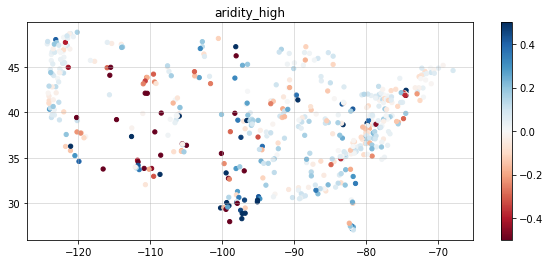

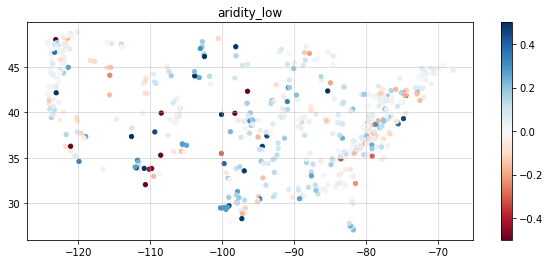

In [174]:
for metric in results_df.columns[:2]:

    fig = plt.figure(figsize=([10,4]))

#     title = metric.split('_')[1:-1]
#     title = [x.capitalize() for x in title]
#     title = ' '.join(title)

    im = plt.scatter(results_df['gauge_lon'], 
              results_df['gauge_lat'],
              c=results_df[metric],
               s=18,
                    vmin=-0.5,
                        vmax=0.5,
                    cmap='RdBu')
    
    ax = fig.add_subplot(111)

    plt.title(f'{metric}')
#     plt.ylabel('Long.')
#     plt.xlabel('Lat.')
    plt.grid(alpha=0.5)
    plt.colorbar(ax = [ax])#,orientation='horizontal')
    plt.show()

I did the difference of random - extreme experiment for 2 models

Then i took the difference of the nse differences for those two models and plotted them (all-nwm)

In [175]:
def _mask_nans(sim, obs):
  mask = np.logical_and(~np.isnan(obs), ~np.isnan(sim))
  return mask

In [176]:
# initialize storage
metric_attribute_corrs = pd.DataFrame(index=attributes.columns, columns=results_df.columns[:2]) 

for metric in results_df.columns[:2]:
  for attribute in attributes.columns:
    att = attributes[attribute].astype(float)
    met = results_df[metric].astype(float)
    mask = _mask_nans(att, met)
    metric_attribute_corrs[metric][attribute] = np.corrcoef(att[mask], met[mask])[0,1]
metric_attribute_corrs.head()

,aridity_high,aridity_low
p_mean,-0.020839,0.002202
pet_mean,0.109245,-0.024649
p_seasonality,0.053478,0.030092
frac_snow,-0.082422,-0.035321
aridity,0.065543,-0.078572


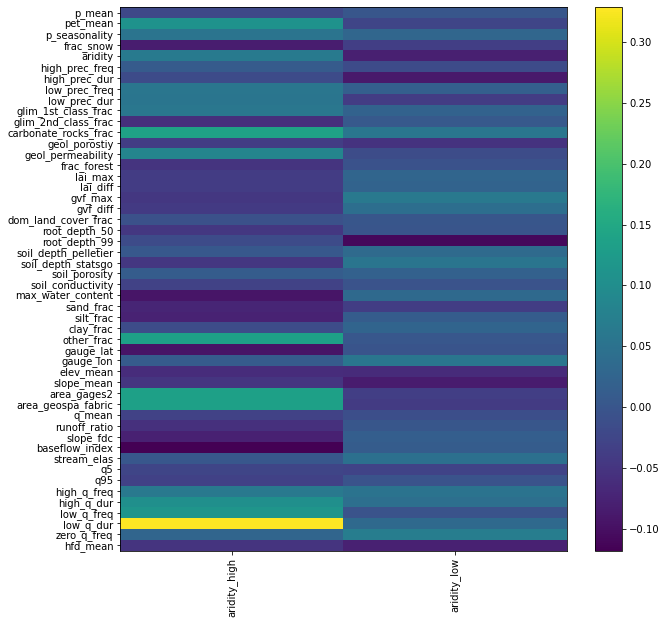

In [177]:
fig = plt.figure(figsize=(10, len(attributes.columns)/5))
im = plt.imshow(metric_attribute_corrs.astype(float), aspect='auto')
plt.xticks(range(len(metric_attribute_corrs.columns)), labels=metric_attribute_corrs.columns, rotation=90)
plt.yticks(range(len(attributes.columns)), labels=attributes.columns)
fig.colorbar(im)

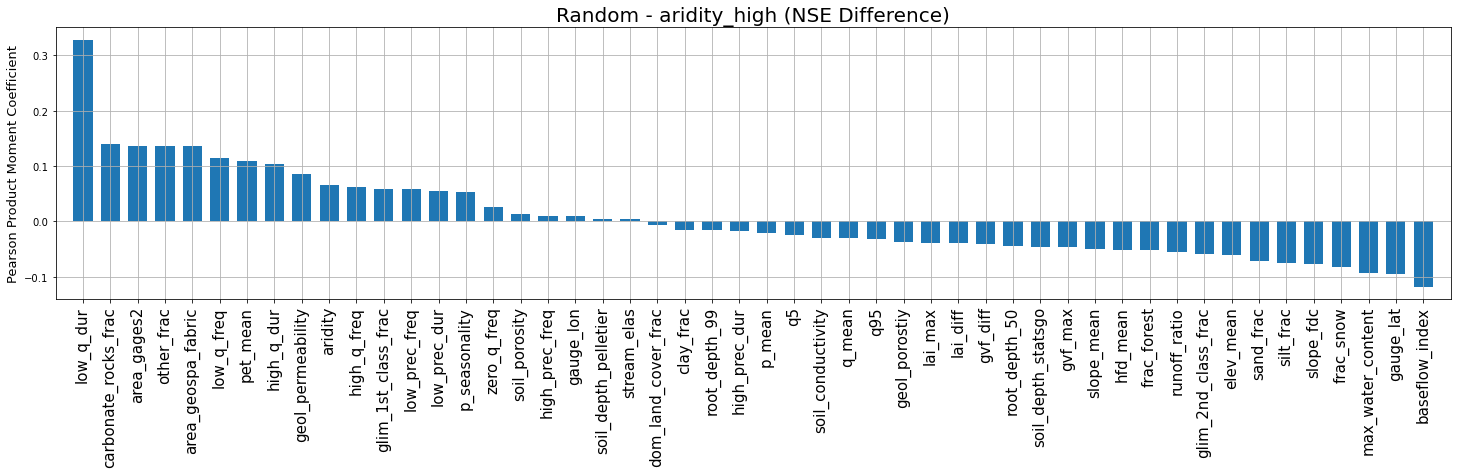

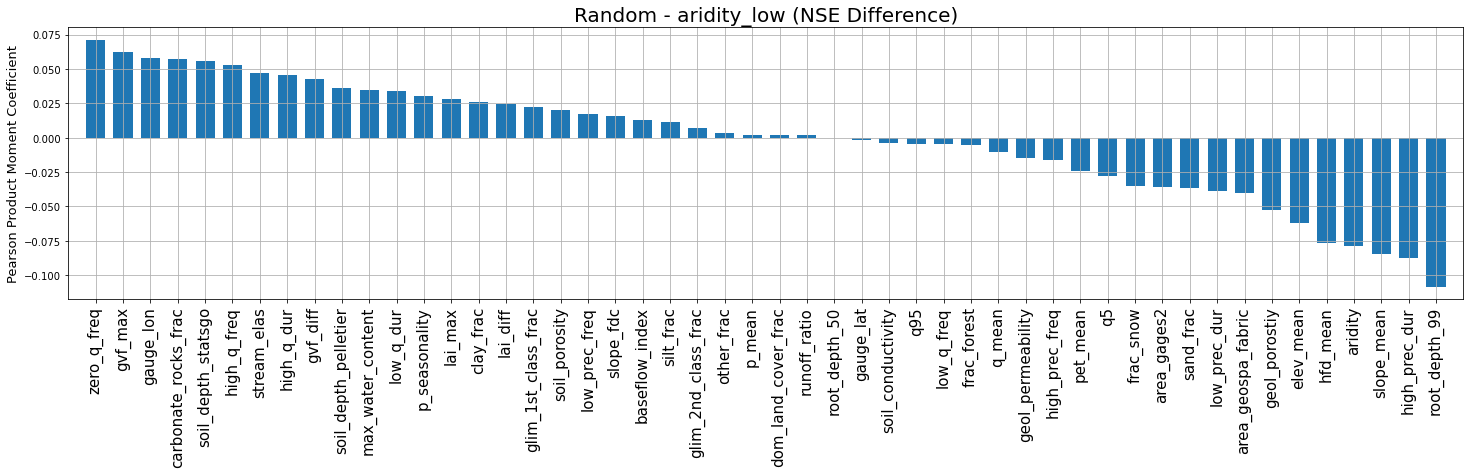

In [179]:
for metric in metric_attribute_corrs.columns:
    
        title = metric.split('_')[1:-1]
        title = [x.capitalize() for x in title]
        title = ' '.join(title)

        fig = plt.figure(figsize=(25, 5))
        plt.bar(attributes.columns, metric_attribute_corrs[metric].sort_values(ascending=False),width=0.7)
        plt.xticks(range(len(attributes.columns)),
                   labels=metric_attribute_corrs[metric].sort_values(ascending=False).index, rotation=90,fontsize=15)
        plt.grid()
        plt.xlim(0-1,len(attributes.columns))
        plt.ylabel('Pearson Product Moment Coefficient',fontsize=13)
        plt.title(f'Random - {metric} (NSE Difference)',fontsize=20)
        plt.show()

In [158]:
# Number of k-fold splits.
n_kfold = 10
n_trees = 200
drop_attributes = ['gauge_lat', 'gauge_lon']

In [162]:
def _make_predictors(metric):
  predictand = results_df[metric].copy()
  predictors = attributes.copy()
  joined = pd.concat([predictand, predictors], axis=1).dropna(axis=0)
  predictand = joined[metric]
  predictors = joined.drop(metric, axis=1)

  predictors.drop(drop_attributes, axis=1, inplace=True)
  print(f'There are {predictors.shape[1]} predictors.')
  print(f'There are {predictors.shape[0]} samples.')

  return predictors, predictand

def _train_kfold(predictors, predictand):
  # Initialize storage.
  basins = list(predictand.index)
  y_hat = pd.Series(index=basins)

  # Create a separate split for each ensemble member.
  kf = model_selection.KFold(n_splits=n_kfold, random_state=None, shuffle=True)

  # Train and test the model.
  for kfold, (train_index, test_index) in enumerate(kf.split(basins)):
    print(f'Training fold # {kfold}')

    # Train/test split.
    train_basins = [basins[idx] for idx in train_index]
    test_basins = [basins[idx] for idx in test_index]
    train_y = predictand.loc[train_basins]#.dropna()
    train_x = predictors.loc[train_y.index]
    test_x = predictors.loc[test_basins]

    # RF model with 1000 trees.
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
    rf.fit(train_x, train_y)

    # Predictions.
    y_hat.loc[test_basins] = rf.predict(test_x)

  return y_hat

def _score_regression(predictand, y_hat, metric):
  # Skill in predicting where we will do well.
  y_hat.name = f'Predicted {metric}'
  rf_results = pd.concat([predictand.astype(float), y_hat.astype(float)], axis=1).dropna()
  r2 = np.corrcoef(rf_results.values.transpose())[0,1]
  print(f'The r2 value for the kfold predictions is {r2}.')

  plt.scatter(rf_results[metric], rf_results[f'Predicted {metric}'])
  plt.plot((-100,1), (-100,1), 'k--')
  plt.grid()
  plt.axis([-1,1,-1,1])
  plt.xlabel(f'True Model Score: {metric}')
  plt.ylabel(f'Predicted Model Score: {metric}')
  plt.title(metric)

def _plot_feature_importances(predictors, predictand):
  # Train a predictor with all of the data.
  rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
  rf.fit(predictors, predictand)

  # Extract importances.
  importance_stds = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
  importances = pd.Series(index=predictors.columns, data=rf.feature_importances_)

  # Plot.
  fig, ax = plt.subplots(figsize=(30,7))
  importances.plot.bar(yerr=importance_stds, ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")

def nonlinear_correlation_analysis(metric):
  predictors, predictand = _make_predictors(metric)
  y_hat = _train_kfold(predictors, predictand)
  _score_regression(predictand, y_hat, metric)
  _plot_feature_importances(predictors, predictand)
  return y_hat

There are 48 predictors.
There are 514 samples.
Training fold # 0


/home/lmqualls/anaconda3/envs/neuralhydrology/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Training fold # 1
Training fold # 2
Training fold # 3
Training fold # 4
Training fold # 5
Training fold # 6
Training fold # 7
Training fold # 8
Training fold # 9
The r2 value for the kfold predictions is -0.049084588824052186.


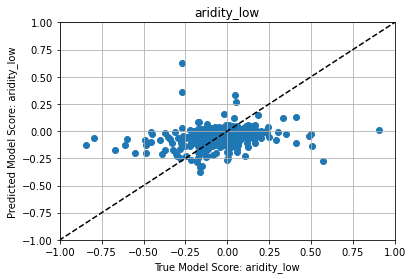

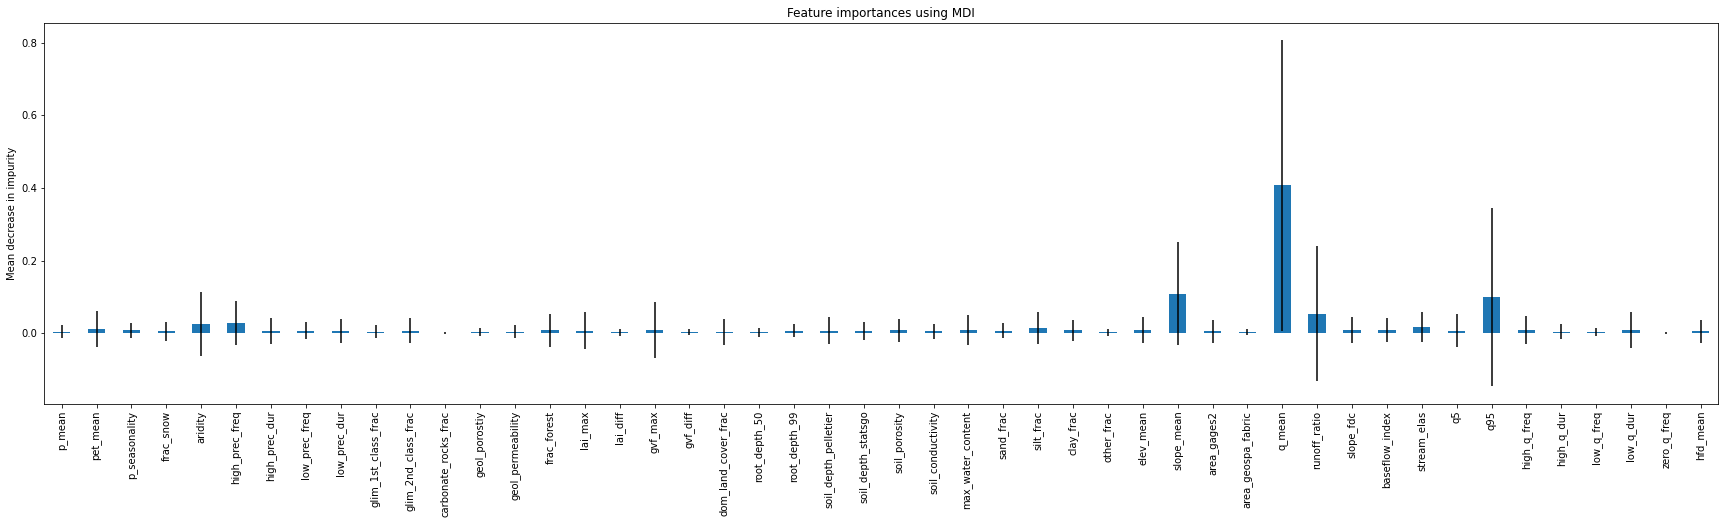

In [166]:
y_hat = nonlinear_correlation_analysis(metric)
nse_predictions = pd.concat([results_df[metric], y_hat])#, attributes[['gauge_lat', 'gauge_lon']]], axis=1)